In [1]:
import yaml
import numpy as np
from omegaconf import OmegaConf
from yolo.module.model_module import ModelModule
from yolo.module.data_module import DataModule

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

from yolo.module.model.yolox.utils.boxes import postprocess
from yolo.utils.eval.evaluation import to_coco_format, evaluation

## データ、モデルの用意

In [2]:
yaml_file = "./../config/notebook.yaml"
with open(yaml_file, 'r') as file:
    config = yaml.safe_load(file)
config = OmegaConf.create(config)

data = DataModule(config)
model = ModelModule(config)

In [3]:
data.setup('fit')

Train dataset size: 536
Validation dataset size: 536
Validation dataset size: 536


In [4]:
train_dataset = data.train_dataset
val_dataset = data.valid_dataset

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from yolo.module.data.dataset.dsec.label import CLASSES

def plot_image_with_bboxes(image, bboxes, labels):
    fig, ax = plt.subplots(1)
    # 画像を表示
    ax.imshow(image)
    
    # バウンディングボックスを描画
    for bbox, label in zip(bboxes, labels):
        # バウンディングボックスの情報を取得 (cx, cy, w, h)
        cx, cy, w, h = bbox
        # 左上の座標に変換 (x_min, y_min)
        x_min = cx - w / 2
        y_min = cy - h / 2
        # 四角形を描画
        rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # クラスラベルを表示
        class_name = CLASSES[int(label)]
        ax.text(x_min, y_min, class_name, color='white', fontsize=12, backgroundcolor='red')

    plt.axis('off')
    plt.show()


## trainデータセットのplot

In [6]:
index = 0
train_img, train_label, train_info, train_id = train_dataset[index]

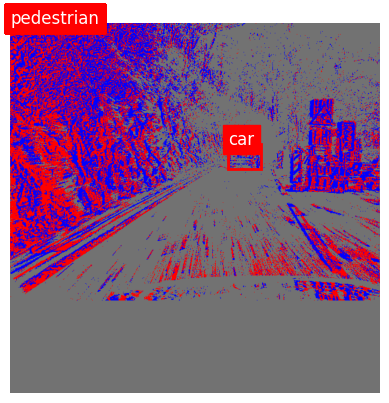

In [7]:
## 正解label
image = np.transpose(train_img, (1, 2, 0))
labels = train_label[:, 0]
bboxes = train_label[:, 1:]

plot_image_with_bboxes(image, bboxes=bboxes, labels=labels)

## val データセットのplot

In [8]:
index = 200
val_img, val_label, val_info, val_id = val_dataset[index]

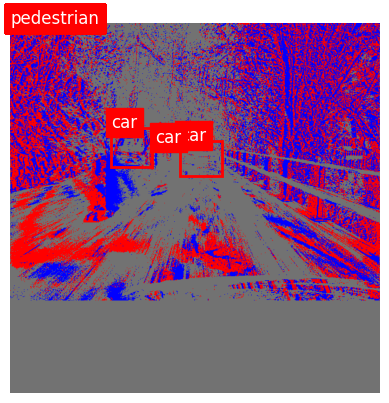

In [9]:
## 正解label
image = np.transpose(val_img, (1, 2, 0))
labels = val_label[:, 4]
bboxes = val_label[:, 0:4]
x1 = val_label[:, 0]
y1 = val_label[:, 1]
x2 = val_label[:, 2]
y2 = val_label[:, 3]

# center_x, center_yを計算
center_x = (x1 + x2) / 2
center_y = (y1 + y2) / 2

# w, hを計算
w = x2 - x1
h = y2 - y1

# 新しい形に変換
bboxes = np.stack([center_x, center_y, w, h], axis=1)
plot_image_with_bboxes(image, bboxes=bboxes, labels=labels)

In [10]:
import torch
output_postprocessed = [torch.tensor([[294., 203., 367., 263, 0.9 , 0.9,   2.],
                                      [251., 206., 266., 219., 0.9, 0.9, 2.],
                                      [175., 180., 245., 249., 0.9, 0.9, 2 ]])]

if config.dataset.name == "coco":
    from yolo.module.data.dataset.coco.coco_classes import COCO_CLASSES as CLASSES
elif config.dataset.name == "dsec":
    from yolo.module.data.dataset.dsec.label import CLASSES
            
classes = CLASSES
categories = [{"id": idx + 1, "name": name} for idx, name in enumerate(classes)]

tensor_label = torch.from_numpy(val_label)
tensor_label = tensor_label.unsqueeze(0)
num_data = len(tensor_label)
gt, pred = to_coco_format(gts=tensor_label, detections=output_postprocessed, categories=categories, height=640, width=640)

# COCO evaluationでスコアを取得
scores = evaluation(Gt=gt, Dt=pred, num_data=num_data)


creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).


In [11]:
scores

{'AP': np.float64(1.0),
 'AP_50': np.float64(1.0),
 'AP_75': np.float64(1.0),
 'AP_S': np.float64(0.9999999999999998),
 'AP_M': np.float64(1.0),
 'AP_L': np.float64(-1.0)}

## 推論

In [ ]:
ckpt = torch
model

In [12]:


val_img_tensor = torch.from_numpy(val_img)
val_img_tensor = val_img_tensor.unsqueeze(0).to(torch.float32)

In [15]:
model.model.eval()
preds = model(val_img_tensor, None)
processed_pred = postprocess(prediction=preds,
                            num_classes=config.model.head.num_classes,
                            conf_thre=config.model.postprocess.conf_thre,
                            nms_thre=config.model.postprocess.nms_thre)

if config.dataset.name == "coco":
    from yolo.module.data.dataset.coco.coco_classes import COCO_CLASSES as CLASSES
elif config.dataset.name == "dsec":
    from yolo.module.data.dataset.dsec.label import CLASSES
            
classes = CLASSES
categories = [{"id": idx + 1, "name": name} for idx, name in enumerate(classes)]
num_data = len(val_label)
gt, pred = to_coco_format(gts=val_label, detections=processed_pred, categories=categories, height=640, width=640)

# COCO evaluationでスコアを取得
scores = evaluation(Gt=gt, Dt=pred, num_data=num_data)
